In [1]:
# %pip install prophet
# %pip install Cython
# %pip install pystan
# %pip install --upgrade prophet cmdstanpy
# %pip install optuna
# %pip install optuna-integration
# %pip install statsmodels
# %pip install darts



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

import tensorflow as tf
from tensorflow.keras.layers import Normalization, LSTM, Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

Описание проекта

In [3]:
sales = pd.read_csv('datasets/mock_kaggle.csv', index_col=[0], parse_dates=[0])
sales.head()

,venda,estoque,preco
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


In [4]:
sales.columns = ['sales', 'stock', 'price']
sales.head()

,sales,stock,price
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


In [5]:
sales = sales.sort_index()
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 937 entries, 2014-01-01 to 2016-07-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   937 non-null    int64  
 1   stock   937 non-null    int64  
 2   price   937 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 29.3 KB


In [6]:
sales.index.is_monotonic_increasing

True

In [7]:
print(sales.isnull().sum())

sales    0
stock    0
price    0
dtype: int64


In [8]:
sales = sales.dropna()

In [9]:
print(sales.isnull().sum())

sales    0
stock    0
price    0
dtype: int64


In [10]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
        # Размер занимаемой памяти до оптимизации (в Мб)
        before_size = df.memory_usage().sum() / 1024**2    
        for column in df.columns:
            column_type = df[column].dtypes
            if column_type in numerics:
                column_min = df[column].min()
                column_max = df[column].max()
                if str(column_type).startswith('int'):
                    if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                        df[column] = df[column].astype(np.int8)
                    elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                        df[column] = df[column].astype(np.int16)
                    elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                        df[column] = df[column].astype(np.int32)
                    elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                        df[column] = df[column].astype(np.int64)  
                else:
                    if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                        df[column] = df[column].astype(np.float32)
                    else:
                        df[column] = df[column].astype(np.float64)    
        # Размер занимаемой памяти после оптимизации (в Мб)
        after_size = df.memory_usage().sum() / 1024**2
        if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                             .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
        return df
optimize_memory_usage(sales, print_size=True)

Размер использования памяти: до  0.03 Mb - после  0.01 Mb (50.0%)


,sales,stock,price
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29
...,...,...,...
2016-07-27,98,3179,2.39
2016-07-28,108,3071,2.39
2016-07-29,128,4095,2.39


Анализ данных

In [11]:
# sales = sales['2015-01':'2015-02']

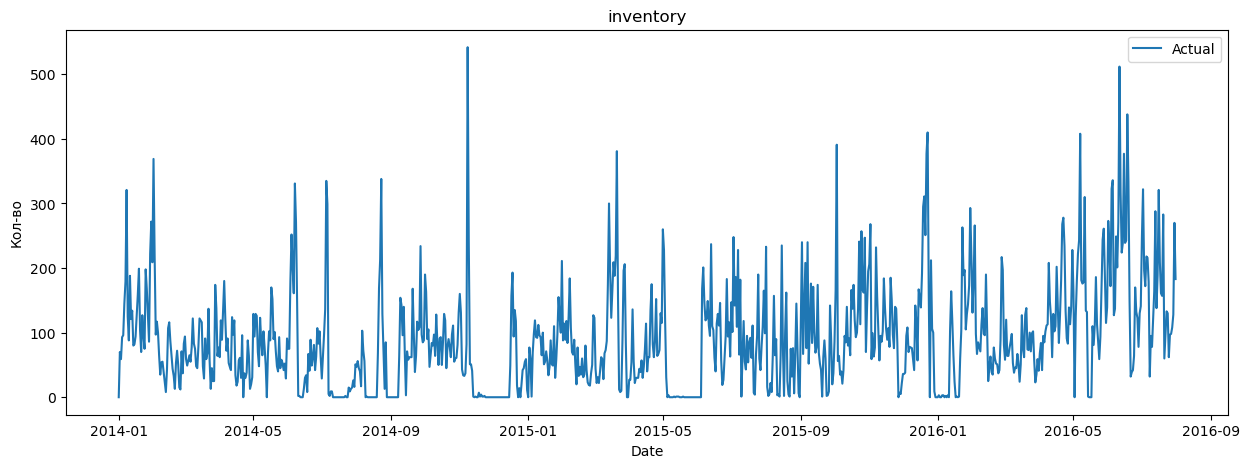

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(sales['sales'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Кол-во')
plt.title('inventory')
plt.legend()
plt.show()

Выделение сезонности

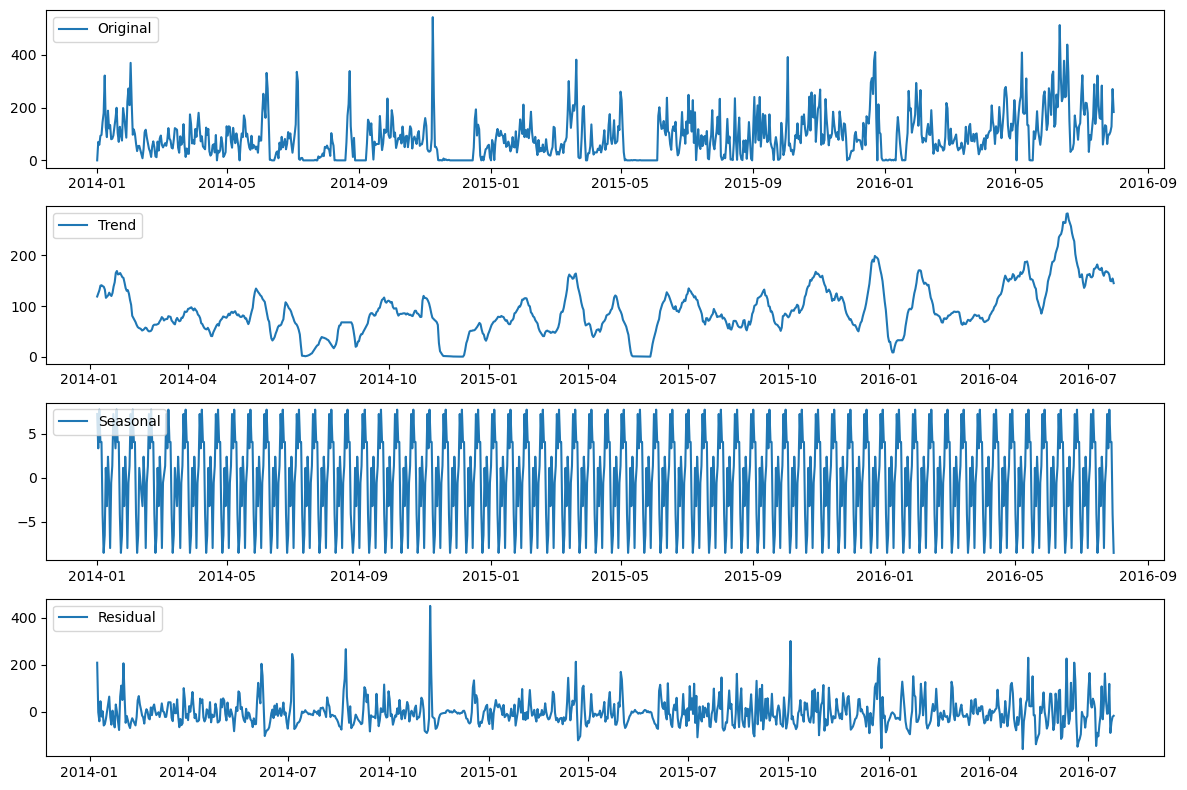

In [13]:
decomposition = sm.tsa.seasonal_decompose(sales['sales'], model='additive', period=15) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(sales['sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Обучение    

In [16]:
values = sales.values
scaler = MinMaxScaler()
values = scaler.fit_transform(values)

y_scaler = MinMaxScaler()
y_scaler.fit(sales["sales"].values.reshape(-1,1))

df = pd.DataFrame(values, columns=["Sales", "Stock", "Price"])

In [17]:
df.head()

,Sales,Stock,Price
0,0.000000,0.687881,0.432886
1,0.129151,0.678196,0.432886
2,0.108856,0.670033,0.432886
3,0.171587,0.657167,0.432886
4,0.177122,0.643885,0.432886


In [18]:
test_size = 30
train = df.iloc[:-test_size, :]
y_train = train["Sales"].to_numpy()
x_train = train.to_numpy()

test  = df.iloc[-test_size:]
y_test = test["Sales"].to_numpy()
x_test = test.to_numpy()

In [19]:
length = 1
train_generator = TimeseriesGenerator(x_train, y_train, length=length, batch_size=1)
test_generator = TimeseriesGenerator(x_test, y_test, length=length, batch_size=1)

In [20]:
number_of_features = 3  # (price, stock, sales)
number_of_targets = 1   # (sales)

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=(length, number_of_features)))
model.add(Dense(number_of_targets))

model.compile(
    optimizer="adam",
    loss="mse" 
)

early_stopping = EarlyStopping(monitor="val_loss")

c:\Users\vanya\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.fit(
    train_generator,
    epochs=20,
    callbacks=[early_stopping],
    validation_data=test_generator,
    shuffle=False
)

Epoch 1/20
179/906 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.0320

c:\Users\vanya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


906/906 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0189 - val_loss: 0.0181
Epoch 2/20
906/906 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - loss: 0.0115 - val_loss: 0.0181


In [22]:
predictions = model.predict(test_generator)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [23]:
y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))
predictions = y_scaler.inverse_transform(predictions.reshape(-1,1))

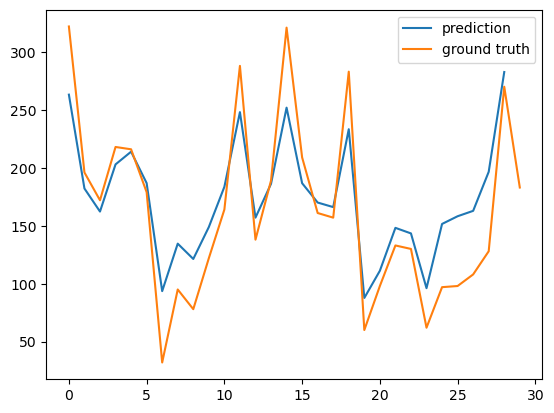

In [24]:
plt.plot(predictions, label="prediction")
plt.plot(y_test, label="ground truth")
plt.legend()
plt.show()